<h3> Decision Tree </h3>

Loading required package: grid
Loading required package: mvtnorm
Loading required package: modeltools
Loading required package: stats4
Loading required package: strucchange
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: libcoin

Attaching package: 'partykit'

The following objects are masked from 'package:party':

    cforest, ctree, ctree_control, edge_simple, mob, mob_control,
    node_barplot, node_bivplot, node_boxplot, node_inner, node_surv,
    node_terminal, varimp

Rattle: A free graphical interface for data science with R.
Version 5.2.0 Copyright (c) 2006-2018 Togaware Pty Ltd.
Type 'rattle()' to shake, rattle, and roll your data.
Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite


'data.frame':	967 obs. of  4 variables:
 $ Rooms : int  2 3 2 2 1 3 3 4 3 3 ...
 $ Suburb: Factor w/ 7 levels "Bentleigh East",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Type  : Factor w/ 3 levels "h","t","u": 1 2 1 3 3 1 2 1 3 3 ...
 $ Price : int  1410000 760000 825000 746000 580000 1206000 1115000 1190000 1025000 740000 ...
'data.frame':	96 obs. of  4 variables:
 $ Rooms : int  3 3 3 4 3 3 2 3 2 4 ...
 $ Suburb: Factor w/ 7 levels "Bentleigh East",..: 3 3 6 1 5 5 7 4 5 2 ...
 $ Type  : Factor w/ 3 levels "h","t","u": 1 1 1 1 1 2 1 1 1 1 ...
 $ Price : int  841000 784000 721000 1010000 1305000 790000 510000 1365000 775000 1802500 ...

Model formula:
Type ~ Rooms + Suburb

Fitted party:
[1] root
|   [2] Rooms <= 2
|   |   [3] Suburb in Bentleigh East, Essendon, Reservoir: u (n = 132, err = 46.2%)
|   |   [4] Suburb in Brunswick, Coburg, Pascoe Vale, Preston: h (n = 143, err = 37.1%)
|   [5] Rooms > 2
|   |   [6] Suburb in Bentleigh East: h (n = 157, err = 31.8%)
|   |   [7] Suburb in Brunswick, C

ERROR: Error in xy.coords(x, y, recycle = TRUE, setLab = FALSE): 'x' is a list, but does not have components 'x' and 'y'


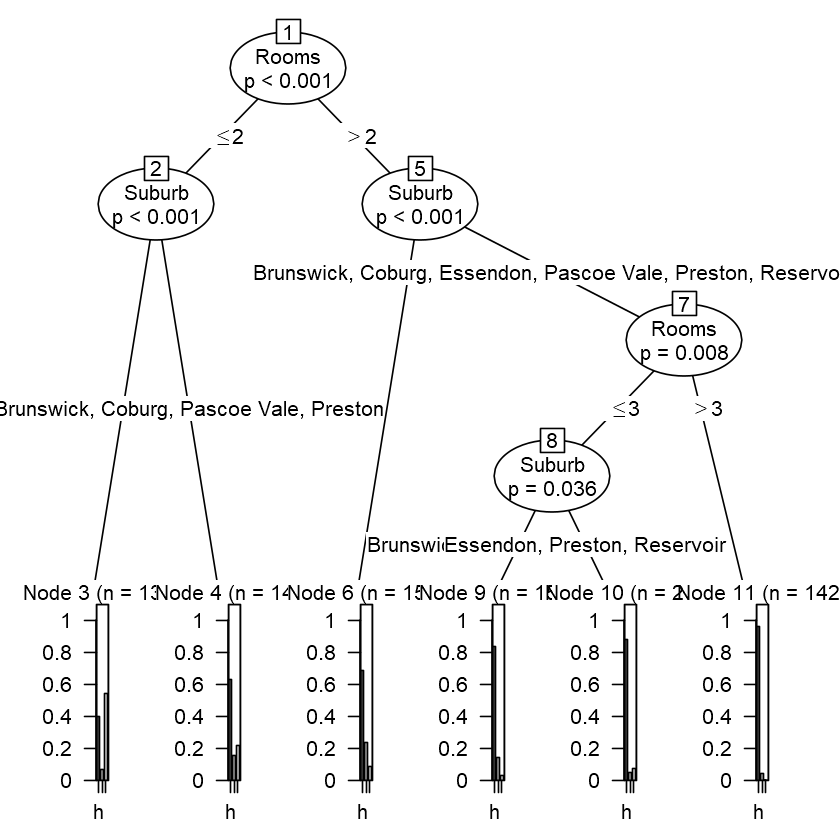

In [1]:
library("party")
library("partykit")
library(tree)
library(rpart)
library(rattle)
library(magrittr)
library(sqldf)
##chracter variable cannot be more than 32 levels to be considered to predict decision tree
##when we did this function including suburb variable also(after converting into factors, which converts chr into numeric)tree1 <- tree(trainingData$Type ~ Rooms + BuildingArea + Suburb, data=trainingData)
###it showed error since str(trainingData) showed suburb had total 140 levels. But it cannot be more than 32 to predict decision tree, so removed Suburb
RawD <- read.csv("C:\\Realestate\\CleanedRE.csv", header=TRUE,
                 stringsAsFactors =FALSE,
                 strip.white =TRUE,
                 sep = ',', na.strings=c("","NA"))
#names(RawD)
RE8 <- na.omit(RawD)
# str(RE8)
#Subset the suburb with more than 100, since there are decision tree cannot plot these many cities, so better to take subset
##and take high frequency number, we can do this either by sqldf or by table and then subsetting by putting conditions
##groupby: group every category inside particular variable and count them by group_by. Count is inside select funt.
suburb <- sqldf("select Suburb, Count(Suburb) as TotSub
                from RE8
                group by Suburb
                having Totsub > 100")

xRE8 <- sqldf("select Rooms, Suburb, Type, Price from RE8
              where Suburb in (select Suburb from suburb)")
xRE8$Type %<>% factor #without changing the data, variable gets converted into numeric levels
xRE8$Suburb %<>% factor
str(xRE8)
set.seed(100)  # setting seed to reproduce results of random sampling
trainingRowIndex <- sample(1:nrow(xRE8), 0.10*nrow(xRE8)) # row indices for training data
trainingData <- xRE8[trainingRowIndex, ]  # model training data
testData  <- xRE8[-trainingRowIndex, ]
str(trainingData)
#MODEL1 Rooms+Suburb+Type
tree1 <- ctree(Type ~ Rooms + Suburb, data=xRE8)
print(tree1)

plot(tree1)
text(tree1)
#MODEL2 Rooms+Price+Type
#Now first we will divide price in different levels so that it's easier for code to distinguish and draw the tree faster 
##otherwise it had to read so many rows for price.
# 1lakh to 4.99 lakh = V LOW
# 5 lakh to 9.99 lakh = LOW
# 10 lakh to 14.99 lakh =MEDIUM
# 15 lakh to 19.99 lakh = HIGH
# >= 20 lakh    = HIGHEST
# new column = Price Range
xRE8$pricerange <-  ifelse(xRE8$Price>100000 & xRE8$Price<499999,"1" ,
                                           ifelse(xRE8$Price>500000 & xRE8$Price<999999,"2" ,
                                                  ifelse(xRE8$Price>1000000 & xRE8$Price<1499999 ,"3" ,
                                                         ifelse(xRE8$Price>1500000 & xRE8$Price<1999999,"4" ,
                                                                ifelse(xRE8$Price>2000000 ,"5", "99"
                                                  )))))
str(xRE8)
xRE8$pricerange %<>% factor
tree2 <- ctree(pricerange ~ Rooms + Type, data=xRE8)
print(tree2)
plot(tree2) #add legend for 1,2,3 till 99 somethng else
text(tree2)